In [1]:
# расскоментируйте код ниже, чтобы установить все зависимости
# !pip install -q \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     pandas==2.0.3 \
#     scipy==1.10.1 \
#     numpy==1.24.3 \
#     torch==2.0.1

In [1]:
import polars as pl
import pandas as pd
import numpy as np

from typing import List
from tqdm import tqdm

import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Загрузим данные

In [2]:
# раскоментируйте следующие строчки, чтобы загрузить датасет
# !wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip -q ml-1m.zip

replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
ratings = pd.read_csv(
    'ml-1m/ratings.dat', delimiter='::', header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'], 
    engine='python'
)
ratings = pl.from_pandas(ratings).filter(pl.col('rating') >= 4)
ratings

user_id,item_id,rating,timestamp
i64,i64,i64,i64
1,1193,5,978300760
1,3408,4,978300275
1,2355,5,978824291
1,1287,5,978302039
1,2804,5,978300719
1,594,4,978302268
1,919,4,978301368
1,595,5,978824268
1,938,4,978301752


In [4]:
grouped_df = (
    ratings
    .groupby('user_id')
    .agg([
        pl.col('item_id').apply(lambda x: x[:-3]).alias('train_item_ids'),
        pl.col('rating').apply(lambda x: x[:-3]).alias('train_ratings'),
        pl.col('item_id').apply(lambda x: x[-3:]).alias('test_item_ids'),
        pl.col('rating').apply(lambda x: x[-3:]).alias('test_ratings'),
    ])
    .filter(pl.col('train_item_ids').list.lengths() > 0)
)
grouped_df

user_id,train_item_ids,train_ratings,test_item_ids,test_ratings
i64,list[i64],list[i64],list[i64],list[i64]
840,"[2051, 2054, … 1240]","[4, 5, … 4]","[1242, 3785, 1247]","[5, 5, 5]"
5880,"[3791, 3793, … 553]","[4, 5, … 4]","[1089, 2034, 1095]","[5, 4, 5]"
984,"[3789, 2988, … 1097]","[4, 4, … 4]","[1240, 2983, 1247]","[4, 4, 5]"
3496,"[6, 745, … 2700]","[4, 4, … 4]","[11, 1968, 356]","[4, 5, 5]"
4584,"[3007, 3038, … 3739]","[5, 5, … 5]","[3742, 2010, 1097]","[5, 5, 5]"
488,"[741, 750, … 1214]","[4, 4, … 5]","[1215, 1240, 3928]","[4, 4, 4]"
5784,"[2805, 1198, … 2762]","[4, 5, … 5]","[2770, 2037, 1097]","[4, 4, 4]"
376,"[2987, 1179, … 1077]","[5, 4, … 5]","[1230, 2973, 1093]","[5, 5, 4]"
3144,"[3793, 3798, … 1215]","[5, 5, … 4]","[1090, 1097, 3785]","[4, 5, 4]"


In [5]:
max_seq_len = int(grouped_df['train_item_ids'].apply(len).median())
print(f"средняя длина сессии {max_seq_len}")

средняя длина сессии 55


In [6]:
ns_exponent = 0.75  # степень популярности объекта
items_set = ratings['item_id'].unique()

# предподсчитаем вероятности в сэмплировании негативных примеров
item_probs = dict()
for item_id, count in ratings.groupby('item_id').count().rows():
    item_probs[item_id] = count / len(ratings)

item_probs = np.array([
    item_probs.get(item_id, 0.)
    for item_id in items_set
])**ns_exponent
item_probs /= np.sum(item_probs)  # normalize so that it's probabilities

In [7]:
TOP_K = 10


def user_hitrate(y_relevant: List[str], y_preds: List[str], k: int = TOP_K) -> int:
    return int(len(set(y_relevant).intersection(y_preds[:k])) > 0)


def user_precision(y_relevant: List[str], y_preds: List[str], k: int = TOP_K) -> float:
    """
    :param y_relevant: shape [n_relevant_items]
    :param y_preds: shape [n_recommended_items]
    :param k: number of top recommended items
    :return: single precision
    """
    if not y_preds:
        return 0.
    
    return user_hitrate(y_relevant, y_preds, k) / k


def user_ap(y_relevant: List[str], y_preds: List[str], k: int = TOP_K) -> float:
    """
    :param y_relevant: shape [n_relevant_items]
    :param y_preds: shape [n_recommended_items]
    :param k: number of top recommended items
    :return: single ap
    """
    if not y_preds:
        return 0.
    
    return np.sum([
        user_precision(y_preds, y_relevant, idx + 1)
        for idx, item in enumerate(y_preds[:k]) if item in y_relevant
    ]) / k

## SASRec
https://arxiv.org/abs/1808.09781

![](https://raw.githubusercontent.com/paddorch/SASRec.paddle/master/images/model.png)

In [10]:
class SASRec(nn.Module):
    def __init__(
        self,
        num_items: int,
        max_seq_length: int,
        embedding_dim: int = 64,
        num_heads: int = 2,
        num_blocks: int = 2,
        dropout_rate: float = 0.5
    ):
        super(SASRec, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.max_seq_length = max_seq_length
        self.num_heads = num_heads
        self.num_blocks = num_blocks

        # эмбеддинги объектов
        self.item_embedding = nn.Embedding(num_items, embedding_dim, padding_idx=0)
        # эмбеддинги позиций
        self.positional_embedding = nn.Embedding(max_seq_length, embedding_dim)
        # механизм внимания
        self.self_attention = nn.MultiheadAttention(
            embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        # полносвязные слои на выходе
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        # dropout и layernorm слои чтобы избежать переобучения
        self.dropout_1 = nn.Dropout(p=dropout_rate)
        self.dropout_2 = nn.Dropout(p=dropout_rate)

        # https://paperswithcode.com/method/layer-normalization
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, input_seq: torch.tensor):
        item_embeddings = self.item_embedding(input_seq)
        
        positional_embeddings = self.positional_embedding(
            torch.arange(input_seq.shape[-1]).unsqueeze(0).to(input_seq.device)
        )

        # Эмбеддинг последовательности состоит из эмбеддингов объектов и позиций
        seq_embeddings = item_embeddings + positional_embeddings
        
        # сделаем маску по тем объектам, которых нет (id = 0) и мы сделали padding
        timeline_mask = input_seq == 0
        seq_embeddings *= ~timeline_mask.unsqueeze(-1)
        
        # attention маска нужна для того, чтобы не заглядывать в будущее
        tl = input_seq.shape[1] 
        attention_mask = ~torch.tril(torch.ones((tl, tl), dtype=torch.bool, device=input_seq.device))

        # применим self-attention, где Q = K = V = эмбеддинги последовательности
        self_attention_output, self_attention_weights = self.self_attention(
            seq_embeddings, seq_embeddings, seq_embeddings,
            attn_mask=attention_mask,
        )
        
        seq_embeddings = seq_embeddings + self.dropout_1(self_attention_output)
        seq_embeddings = self.layer_norm1(seq_embeddings)

        ff_output = self.feed_forward(seq_embeddings)
        
        seq_embeddings = seq_embeddings + self.dropout_2(ff_output)
        seq_embeddings = self.layer_norm2(seq_embeddings)

        return seq_embeddings, self_attention_weights
    
    def predict(self, input_seq: torch.tensor, target_item: int):
        seq_emb = self.forward(input_seq)
        target_emb = self.item_embedding(torch.tensor(target_item))
        print(seq_emb.shape, target_emb.shape)

## Обучение модели

In [13]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
print(f'using {device} device')

using cuda device


In [12]:
# Гиперпараметры модели
embedding_dim = 50
max_seq_length = 62
num_heads = 1
num_blocks = 2

model = SASRec(
    ratings['item_id'].max() + 1,
    embedding_dim=embedding_dim,
    max_seq_length=max_seq_length,
    num_heads=num_heads,
    num_blocks=num_blocks
)
model = model.to(device)

In [13]:
items_set = ratings['item_id'].unique()

def sample_negatives(positives: List[int], n_negatives: int) -> List[int]:
    negatives = np.random.choice(items_set, n_negatives + len(positives), p=item_probs)
    negatives = [item_id for item_id in negatives if item_id not in positives][:n_negatives]
    return negatives

TOP_K = 10
def hitrate(y_relevant: List[str], y_preds: List[str], k: int = TOP_K) -> int:
    return int(len(set(y_relevant).intersection(y_preds[:k])) > 0)
    

n_negatives = 10  # кол-во негативных примеров на один позитивный
batch_size = 128

# сюда будем складывать данные для батчей, которые используются для обучения модели
# это место не самое оптимальное, его можно улучшить с помощью классов датасетов
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
input_seqs: List[List[int]] = []
pos_items: List[int] = []
neg_items: List[List[int]] = []

# также сохраним веса attention для отображения их в следующей ячейке
self_attention_weights_list = []

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.98))
bce_criterion = torch.nn.BCEWithLogitsLoss()

train_df = (
    grouped_df
    # для обучения нужно как минимум два взаимодействия в сессии
    .filter(pl.col('train_item_ids').list.lengths() >= 2)
    .select('user_id', 'train_item_ids')
)

train_losses = []
for epoch in range(100):
    # обучение модели
    model.train()
    for user_id, train_ids in train_df.rows():
        if len(input_seqs) >= batch_size:
            optimizer.zero_grad()

            input_seq = [torch.tensor(input_seq[:max_seq_len][::-1]) for input_seq in input_seqs]
            input_seq = torch.flip(pad_sequence(input_seq, batch_first=True), [-1])

            # кодируем входную последовательность
            seq_emb, self_attention_weights = model(input_seq.to(device))
            seq_emb = seq_emb[:, -1, :]

            # кодируем следующие объекты в сессии (позитивные и негативные)
            pos_emb = model.item_embedding(torch.tensor(pos_items).to(device))
            neg_emb = model.item_embedding(torch.tensor(neg_items).to(device))

            # для удобного подсчета dot-product можно использовать функцию einsum
            pos_logits = torch.einsum('ij,ij->i', seq_emb, pos_emb)
            neg_logits = torch.einsum('ik,ijk->ij', seq_emb, neg_emb)
            
            # в качестве функции ошибки используем обычный BCE loss
            loss = bce_criterion(pos_logits, torch.ones_like(pos_logits))
            loss += bce_criterion(neg_logits, torch.zeros_like(neg_logits))
            train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

            input_seqs, pos_items, neg_items = [], [], []

        if len(train_ids) > max_seq_len:
            # выбираем случайную последовательность длины max_seq_len
            pos_ind = len(train_ids) - 1 - np.random.randint(0, (len(train_ids) - max_seq_len + 1))
            input_seq = train_ids[pos_ind - max_seq_len + 1:pos_ind]
            positives = train_ids[pos_ind]
        else:
            # используем сессию как есть
            input_seq = train_ids[:-1]
            positives = train_ids[-1]

        input_seqs.append(input_seq)
        pos_items.append(positives)
        neg_items.append(sample_negatives(train_ids, n_negatives))

    if epoch % 10 != 0:
        continue
        
    self_attention_weights_list.append(self_attention_weights.mean(0).cpu().detach().numpy())
        
    # оценка модели
    model.eval()
    hitrate_list = []
    for user_id, train_ids, test_ids in tqdm(
        grouped_df.select('user_id', 'train_item_ids', 'test_item_ids').head(1_000).rows()
    ):
        input_seq = [torch.tensor(train_ids[max(0, len(train_ids) - max_seq_len):][::-1])]
        input_seq = torch.flip(pad_sequence(input_seq, batch_first=True), [-1])

        # для предсказания закодируем входную последовательность
        seq_emb, _ = model(input_seq.to(device))
        seq_emb = seq_emb[0, -1, :]
        
        # и посчитаем dot-product с эмбеддингами всех объектов
        probs = torch.einsum('j,ij->i', seq_emb, model.item_embedding.weight).cpu().detach().numpy()
        
        # в качестве рекомендаций выберем top-k ближайших
        recs = [item_id for item_id in np.argsort(probs)[::-1] if item_id not in train_ids][:TOP_K]
        hitrate_list.append(hitrate(test_ids, recs))
        
    print(f'(epoch {epoch})\tHitrate@{TOP_K} = {np.mean(hitrate_list)}, Loss = {np.mean(train_losses)}')
    train_losses = []

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.33it/s]


(epoch 0)	Hitrate@10 = 0.01, Loss = 4.408940502937804


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 55.40it/s]


(epoch 10)	Hitrate@10 = 0.062, Loss = 1.3979306434876346


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.91it/s]


(epoch 20)	Hitrate@10 = 0.077, Loss = 0.8504862542365007


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.19it/s]


(epoch 30)	Hitrate@10 = 0.115, Loss = 0.6564460333626149


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.21it/s]


(epoch 40)	Hitrate@10 = 0.127, Loss = 0.5422700255666316


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.10it/s]


(epoch 50)	Hitrate@10 = 0.135, Loss = 0.47529670848684796


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.36it/s]


(epoch 60)	Hitrate@10 = 0.13, Loss = 0.4247738190643853


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.46it/s]


(epoch 70)	Hitrate@10 = 0.116, Loss = 0.3948383294599578


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.92it/s]


(epoch 80)	Hitrate@10 = 0.093, Loss = 0.36215882404249605


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.86it/s]


(epoch 90)	Hitrate@10 = 0.137, Loss = 0.33975967828129


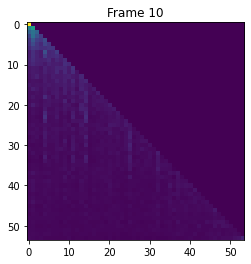

In [14]:
def update(frame):
    image = self_attention_weights_list[frame]
    plt.imshow(image, cmap="viridis", interpolation="nearest")
    plt.title(f'Frame {frame + 1}')

fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, update, frames=len(self_attention_weights_list), interval=200)

# анимацию можно посмотреть, открыв гифку в отдельном окне
ani.save('animation.gif', writer='pillow')

## MultVAE
https://arxiv.org/abs/1802.05814

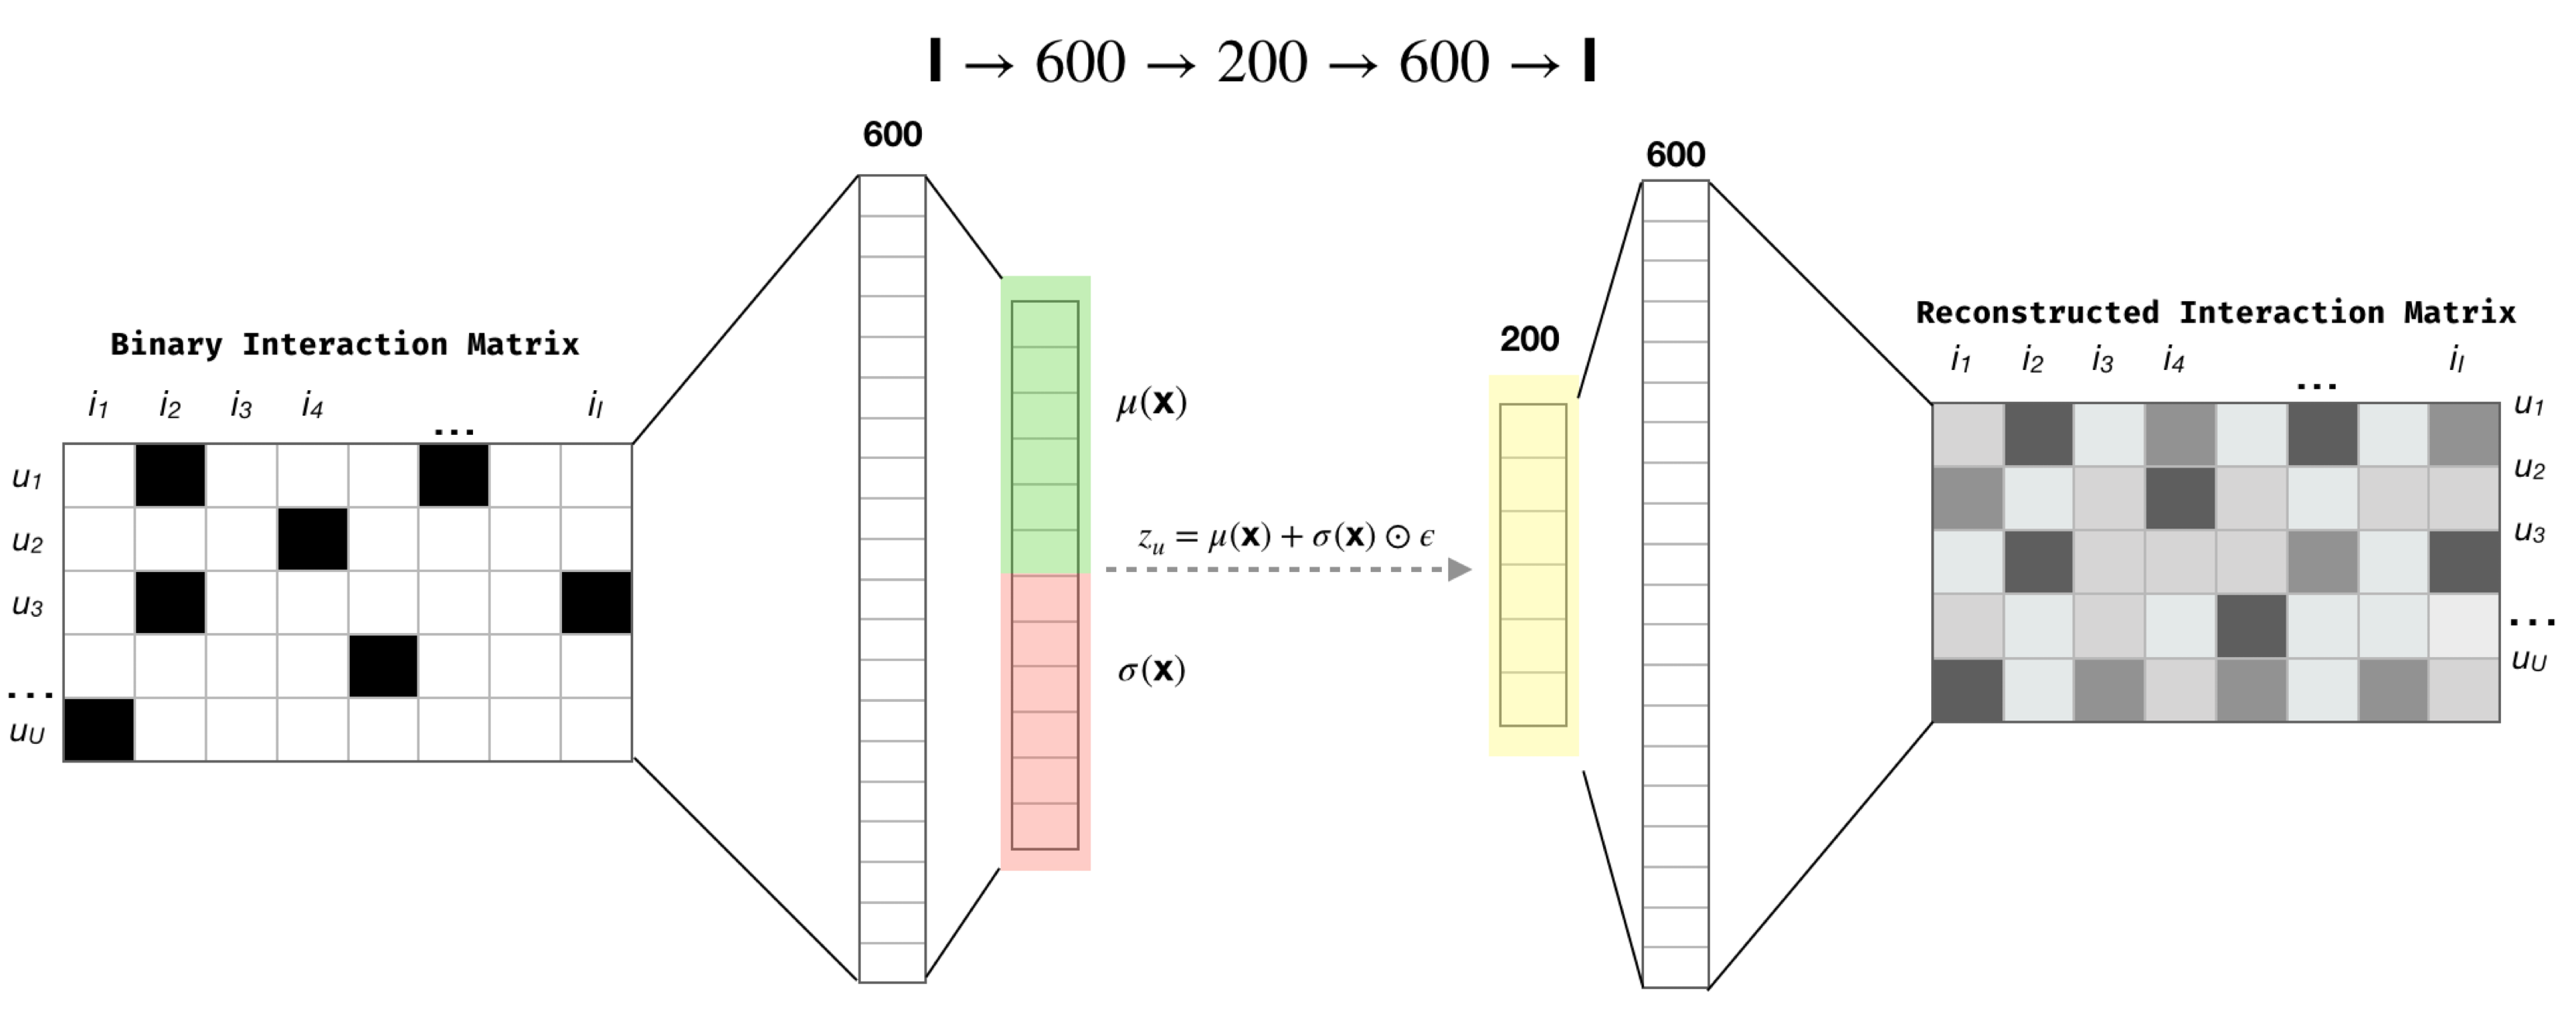

In [8]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, train_item_ids, train_ratings in grouped_df.select(
    'user_id', 'train_item_ids', 'train_ratings'
).rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend(train_ratings)
#     values.extend([1] * len(train_item_ids))

user_item_data = sp.csr_matrix(
    (values, (rows, cols)),
    shape=(ratings['user_id'].max() + 1, ratings['item_id'].max() + 1),
    dtype=np.float32
)
user_item_data

<6041x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 557171 stored elements in Compressed Sparse Row format>

In [9]:
def init_weights(layers):
    for layer in layers:
        if hasattr(layer, 'weight'):
            # xavier инициализация для линейных слоев
            torch.nn.init.xavier_normal_(layer.weight)

        if hasattr(layer, 'bias'):
            # для инициализации смещений используется нормальное распределение
            layer.bias.data.normal_(0.0, 0.001)


class Encoder(nn.Module):
    def __init__(self, hidden_dims: List[int], dropout_p: float = 0.5):
        super().__init__()
        
        # последний слой по сути разделяется на две матрицы весов, можно это сделать таким трюком
        hidden_dims = hidden_dims.copy()
        hidden_dims[-1] *= 2
        
        layers = [nn.Dropout(dropout_p)]
        for i, (in_dim, out_dim) in enumerate(zip(hidden_dims, hidden_dims[1:])):
            layers.append(nn.Linear(in_dim, out_dim))
            if i != len(hidden_dims) - 2:
                layers.append(nn.Tanh())
        self.layers = nn.Sequential(*layers)
        init_weights(self.layers)
        
    def forward(self, x):
        x = F.normalize(x)
        x = self.layers(x)
        mu, logvar = x.chunk(2, dim=-1)
        return mu, logvar
    
    
class Decoder(nn.Module):
    def __init__(self, hidden_dims: List[int]):
        super().__init__()
        layers = []
        for i, (in_dim, out_dim) in enumerate(zip(hidden_dims, hidden_dims[1:])):
            layers.append(nn.Linear(in_dim, out_dim))
            if i != len(hidden_dims) - 2:
                layers.append(nn.Tanh())
        self.layers = nn.Sequential(*layers)
        init_weights(self.layers)
        
    def forward(self, x):
        return self.layers(x)
    
    
class MultVAE(nn.Module):
    def __init__(self, encoder_hidden_dims: List[int], decoder_hidden_dims: List[int], dropout_p: float = 0.5):
        super().__init__()
        
        self.encoder = Encoder(encoder_hidden_dims, dropout_p)
        self.decoder = Decoder(decoder_hidden_dims)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [10]:
def loss_function(recon_x, x, mu, logvar, anneal=1.0):
    bce_loss = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    kld = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return bce_loss + anneal * kld

In [11]:
class Config:
    lr = 1e-3
    wd=0.
    anneal_cap = 0.2
    n_epochs = 500
    seed = 42
    
args = Config()

In [14]:
encoder_hidden_dims = [user_item_data.shape[-1], 600, 200]
decoder_hidden_dims = encoder_hidden_dims[::-1]

torch.manual_seed(args.seed)
model = MultVAE(encoder_hidden_dims, decoder_hidden_dims).to(device)

criterion = loss_function
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=args.lr,
    weight_decay=args.wd
)

data = torch.from_numpy(user_item_data.todense()).to(device)

for epoch in range(args.n_epochs):
    # обучение модели
    model.train()
    anneal = args.anneal_cap * epoch / args.n_epochs
            
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = criterion(recon_batch, data, mu, logvar, anneal)
    loss.backward()
    optimizer.step()

    # оценка модели
    if epoch % 10 == 0:
        model.eval()

        recs = torch.flip(torch.argsort(model(data)[0], -1), [-1]).cpu().numpy()

        hitrate_list = []
        for user_id, user_history, y_rel in grouped_df.select(
            'user_id', 'train_item_ids', 'test_item_ids'
        ).rows():
            user_history = set(user_history)
            y_rec = [
                item_id
                for item_id in recs[user_id][:TOP_K + len(user_history)]
                if item_id not in user_history
            ]
            hitrate_list.append(user_hitrate(y_rel, y_rec))
        print(f'[{epoch} epoch]\tloss = {loss.item():.2f}, Hitrate@{TOP_K} = {np.mean(hitrate_list):.4f} (anneal = {anneal:.4f})')

[0 epoch]	loss = 3369.45, Hitrate@10 = 0.0187 (anneal = 0.0000)
[10 epoch]	loss = 3006.05, Hitrate@10 = 0.0418 (anneal = 0.0040)
[20 epoch]	loss = 2948.68, Hitrate@10 = 0.0189 (anneal = 0.0080)
[30 epoch]	loss = 2929.41, Hitrate@10 = 0.0270 (anneal = 0.0120)
[40 epoch]	loss = 2904.01, Hitrate@10 = 0.0585 (anneal = 0.0160)
[50 epoch]	loss = 2868.26, Hitrate@10 = 0.0863 (anneal = 0.0200)
[60 epoch]	loss = 2854.61, Hitrate@10 = 0.0824 (anneal = 0.0240)
[70 epoch]	loss = 2845.08, Hitrate@10 = 0.0855 (anneal = 0.0280)
[80 epoch]	loss = 2821.07, Hitrate@10 = 0.0918 (anneal = 0.0320)
[90 epoch]	loss = 2792.27, Hitrate@10 = 0.1060 (anneal = 0.0360)
[100 epoch]	loss = 2775.38, Hitrate@10 = 0.1109 (anneal = 0.0400)
[110 epoch]	loss = 2761.29, Hitrate@10 = 0.1160 (anneal = 0.0440)
[120 epoch]	loss = 2741.79, Hitrate@10 = 0.1297 (anneal = 0.0480)
[130 epoch]	loss = 2729.41, Hitrate@10 = 0.1425 (anneal = 0.0520)
[140 epoch]	loss = 2720.91, Hitrate@10 = 0.1457 (anneal = 0.0560)
[150 epoch]	loss = 27